# ライブラリのインポート

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import copy
from IPython.display import display
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from matplotlib.ticker import StrMethodFormatter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# データの読み込みと前処理

In [2]:
# パスの設定

# Train Data
train_data_pass = '/kaggle/input/bike-sharing-demand/train.csv'

# Test Data
test_data_pass = '/kaggle/input/bike-sharing-demand/test.csv'

In [3]:
# Train dataの読み込み
df_train = pd.read_csv(train_data_pass, parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

# 指定位置に年，月，日，時間の列を挿入
df_train.insert(1, 'year', df_train['datetime'].dt.year)
df_train.insert(2, 'month', df_train['datetime'].dt.month)
df_train.insert(3, 'day', df_train['datetime'].dt.day)
df_train.insert(4, 'hour', df_train['datetime'].dt.hour)

# 結果を表示
df_train.head(2)

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [4]:
# Test dataの読み込み
df_test = pd.read_csv(test_data_pass, parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# 指定位置に年，月，日，時間の列を挿入
df_test.insert(1, 'year', df_test['datetime'].dt.year)
df_test.insert(2, 'month', df_test['datetime'].dt.month)
df_test.insert(3, 'day', df_test['datetime'].dt.day)
df_test.insert(4, 'hour', df_test['datetime'].dt.hour)

# 結果を表示
df_test.head(2)

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,2011,1,20,0,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,2011,1,20,1,1,0,1,1,10.66,13.635,56,0.0000


In [5]:
# Train Dataをcasualとregisteredにデータを分割

# 指定されたカラムのみを抽出
df_train_casual = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual']]
df_train_registered = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'registered']]
df_train_count = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']]

print("df_train_casual")
display(df_train_casual.head(2))

print("df_train_registered")
display(df_train_registered.head(2))

print("df_train_count")
display(df_train_count.head(2))

df_train_casual


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8


df_train_registered


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,13
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,32


df_train_count


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40


# データの可視化と分析

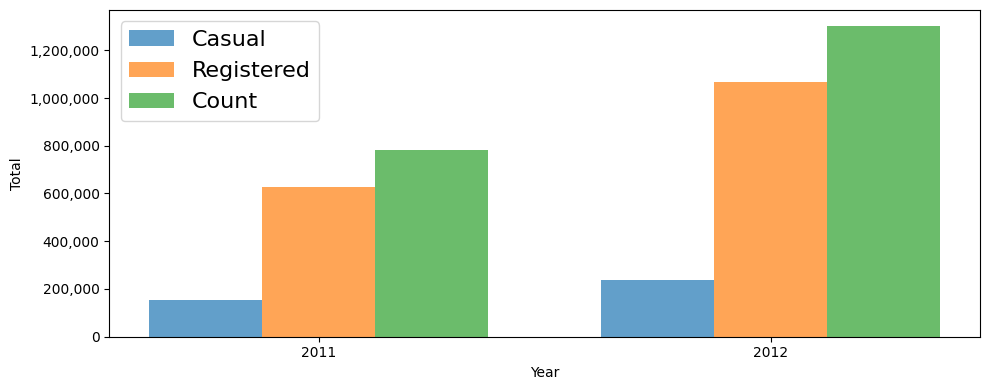

In [6]:
# casual，registered，countの関係を確認

# 年ごとに合計を計算
grouped = df_train.groupby('year')[['casual', 'registered', 'count']].sum()

# グラフの設定
plt.figure(figsize=(10, 4))
x = range(len(grouped))

# 棒グラフをプロット
bar_width = 0.25
plt.bar([i - bar_width for i in x], grouped['casual'], width=bar_width, label='Casual', alpha=0.7)
plt.bar(x, grouped['registered'], width=bar_width, label='Registered', alpha=0.7)
plt.bar([i + bar_width for i in x], grouped['count'], width=bar_width, label='Count', alpha=0.7)

# x軸のラベルを年に設定
plt.xticks(x, grouped.index, rotation=0)

# y軸を元の値で表示
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# 凡例とラベルの設定
# plt.title('Total Counts by Year')
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

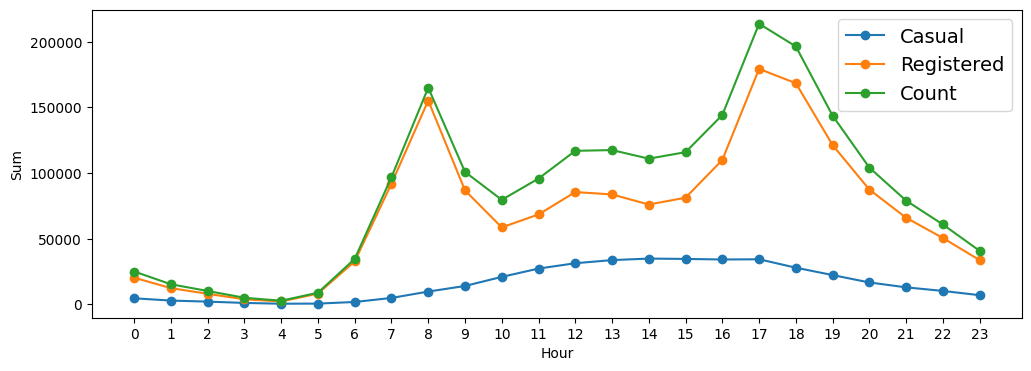

In [7]:
# 時間ごとの合計（2011年と2012年）
hourly_data = df_train.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

plt.figure(figsize=(12, 4))
plt.xticks(hourly_data['hour'])
plt.xlabel('Hour')
plt.ylabel('Sum')
plt.plot(hourly_data['hour'], hourly_data['casual'], marker='o', label='Casual')
plt.plot(hourly_data['hour'], hourly_data['registered'], marker='o', label='Registered')
plt.plot(hourly_data['hour'], hourly_data['count'], marker='o', label='Count')
plt.legend(fontsize=14)
plt.show()

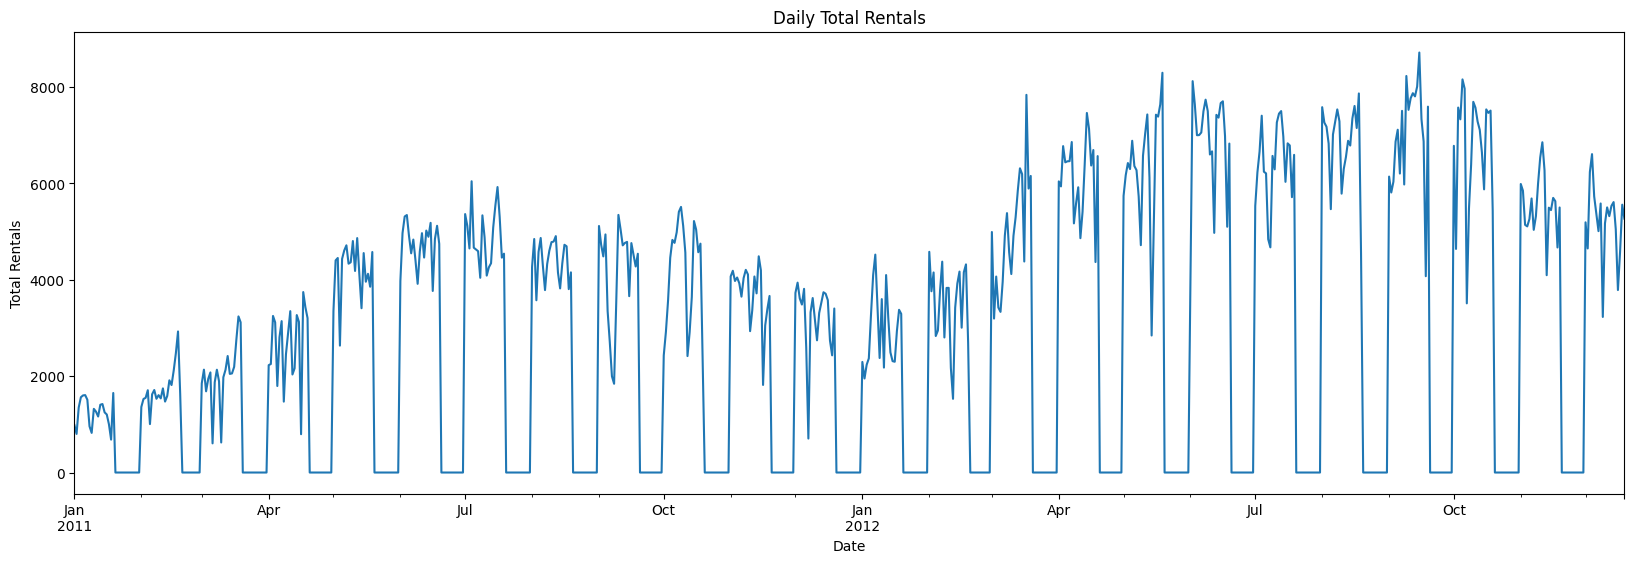

In [8]:
# 時間に基づくレンタル数のトレンド
plt.figure(figsize=(20, 6))
df_total = df_train.copy()
df_total.set_index('datetime', inplace=True)
df_total['count'].resample('D').sum().plot(title='Daily Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.show()

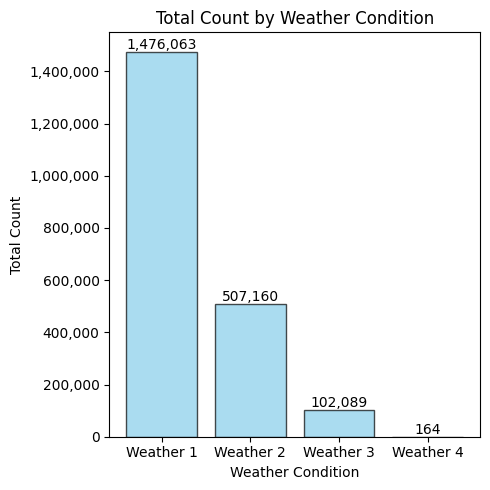

In [9]:
# weather ごとに合計を計算
weather_totals = df_train.groupby('weather')['count'].sum()

# プロット
plt.figure(figsize=(5, 5))
bars = plt.bar(weather_totals.index, weather_totals, color='skyblue', edgecolor='black', alpha=0.7)

# 棒グラフの上に値を表示
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval):,}', ha='center', va='bottom', fontsize=10)

# x軸ラベルとフォーマット設定
plt.xticks(weather_totals.index, [f'Weather {int(i)}' for i in weather_totals.index])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# ラベルと凡例の設定
plt.xlabel('Weather Condition')
plt.ylabel('Total Count')
plt.title('Total Count by Weather Condition')
plt.tight_layout()
plt.show()

In [10]:
# weather が 4 のときの datetime を取得
weather_4_data = df_train[df_train['weather'] == 4]['datetime']

# 結果を表示
print(weather_4_data)

5631   2012-01-09 18:00:00
Name: datetime, dtype: datetime64[ns]


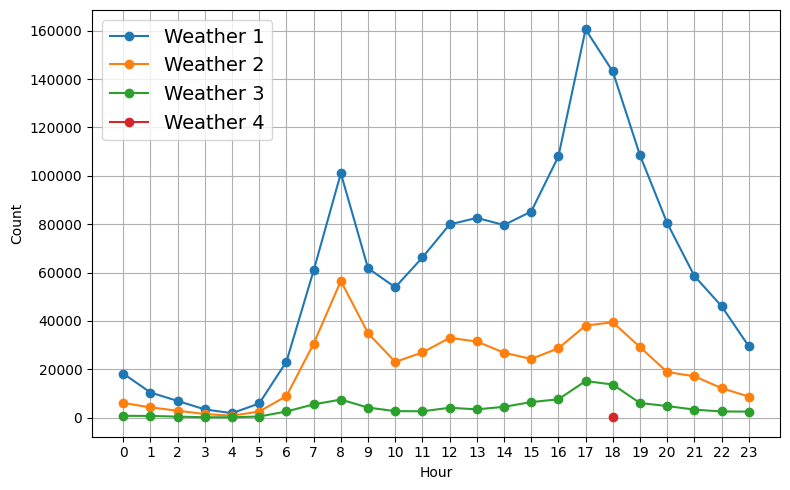

In [11]:
# weather ごとの時間ごとの合計を折れ線グラフで表示
plt.figure(figsize=(8, 5))
weather_groups = df_train.groupby(['weather', 'hour'])['count'].sum().reset_index()

# 各 weather のプロット
for weather_condition in sorted(df_train['weather'].unique()):
    hourly_data = weather_groups[weather_groups['weather'] == weather_condition]
    plt.plot(hourly_data['hour'], hourly_data['count'], marker='o', label=f'Weather {weather_condition}')

# x軸ラベルとフォーマット設定
plt.xticks(range(0, 24))
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# トレーニングデータとテストデータの月ごとの平均気温を計算
monthly_avg_temp_train = df_train.groupby(['year', 'month'])['temp'].mean().reset_index()
monthly_avg_temp_test = df_test.groupby(['year', 'month'])['temp'].mean().reset_index()

# トレーニングデータとテストデータを横に結合
combined_df = pd.merge(
    monthly_avg_temp_train, 
    monthly_avg_temp_test, 
    on=['year', 'month'], 
    suffixes=('_train', '_test')
)

# 2年間の月ごとの平均気温を計算
monthly_avg_combined = combined_df.groupby('month')[['temp_train', 'temp_test']].mean().reset_index()

print("Monthly Average Temperature (Combined for Two Years)")
display(monthly_avg_combined)

Monthly Average Temperature (Combined for Two Years)


,month,temp_train,temp_test
0,1,9.810710,9.458134
1,2,11.793912,13.279454
2,3,15.883988,16.200053
3,4,18.719409,20.222008
4,5,22.674079,27.098437
5,6,27.064496,29.746742
6,7,30.841711,31.184201
7,8,29.736689,27.949990
8,9,25.776934,24.412083
9,10,20.933820,18.475828


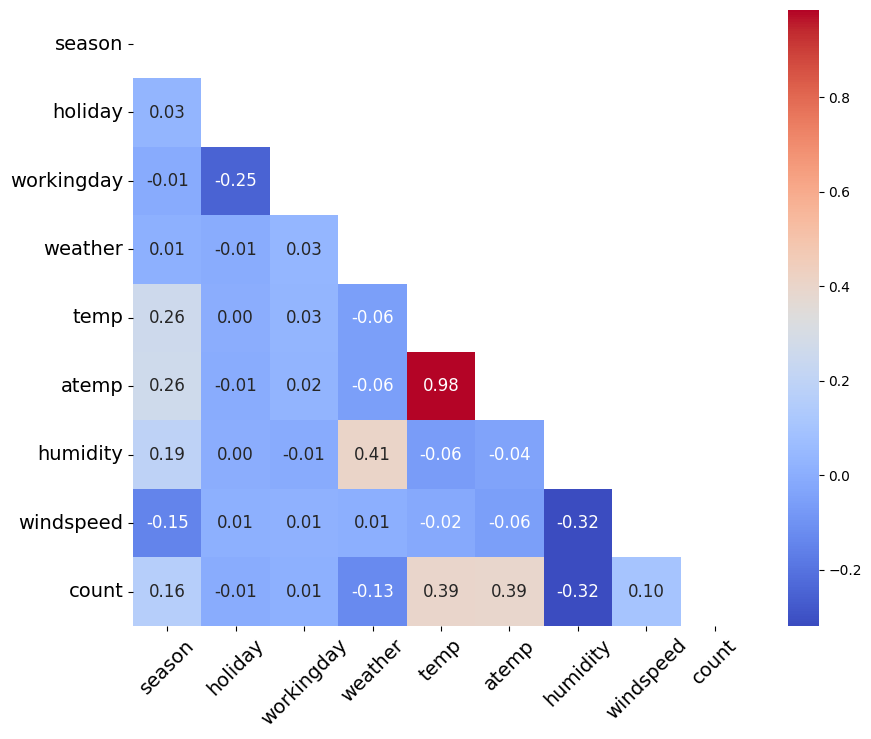

In [13]:
# 考慮するカラムのリスト
columns_to_consider = ['season', 'holiday', 'workingday', 'weather','temp', 'atemp', 'humidity', 'windspeed', 'count']

# 選択したカラムのみを使って相関行列を計算
corr_matrix = df_train[columns_to_consider].corr()

# 対角線の上側をマスク
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# ヒートマップをプロット
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    annot_kws={"size": 12}  # ヒートマップ内のフォントサイズを設定
)
plt.xticks(rotation=45, fontsize=14)  # x軸ラベルを斜めにしてフォントサイズを設定
plt.yticks(fontsize=14)               # y軸ラベルのフォントサイズを設定
# plt.title('Feature Correlations (Selected Columns)', fontsize=14)  # タイトルのフォントサイズを設定
plt.show()

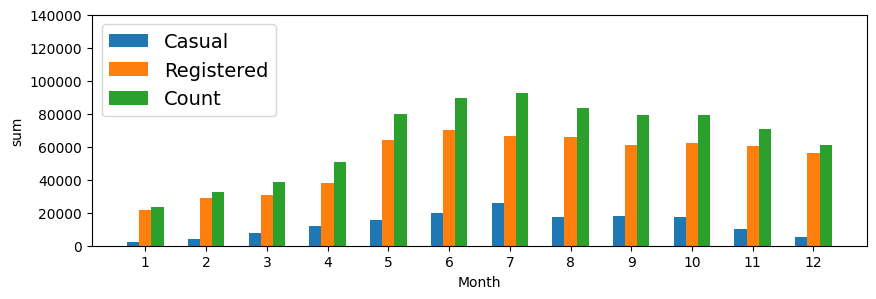

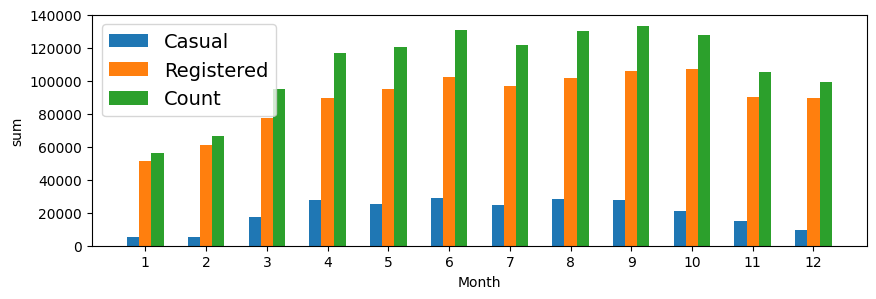

In [14]:
# 月ごとの合計（2011年）
monthly_data_2011 = df_train[df_train['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()

# 月ごとの合計（2012年）
monthly_data_2012 = df_train[df_train['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()

# 2011年の月ごとの棒グラフ
plt.figure(figsize=(10, 3))
plt.bar(monthly_data_2011['month'] - 0.2, monthly_data_2011['casual'], width=0.2, label='Casual')
plt.bar(monthly_data_2011['month'], monthly_data_2011['registered'], width=0.2, label='Registered')
plt.bar(monthly_data_2011['month'] + 0.2, monthly_data_2011['count'], width=0.2, label='Count')
plt.xticks(monthly_data_2011['month'])
plt.xlabel('Month')
plt.ylabel('sum')
plt.legend(fontsize=14)
plt.ylim(0,140000)
plt.show()

# 2012年の月ごとの棒グラフ
plt.figure(figsize=(10, 3))
plt.bar(monthly_data_2012['month'] - 0.2, monthly_data_2012['casual'], width=0.2, label='Casual')
plt.bar(monthly_data_2012['month'], monthly_data_2012['registered'], width=0.2, label='Registered')
plt.bar(monthly_data_2012['month'] + 0.2, monthly_data_2012['count'], width=0.2, label='Count')
plt.xticks(monthly_data_2012['month'])
plt.xlabel('Month')
plt.ylabel('sum')
plt.legend(fontsize=14)
plt.ylim(0,140000)
plt.show()

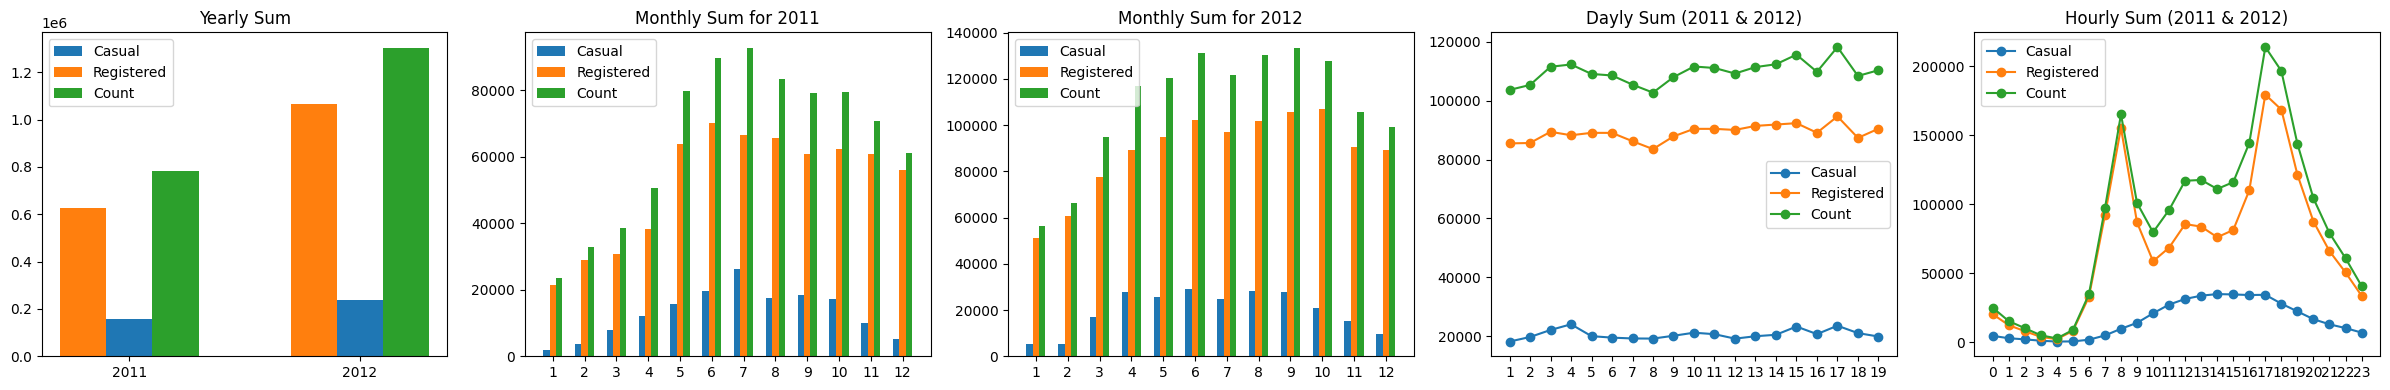

In [15]:
# 年ごとの合計
yearly_data = df_train.groupby('year')[['casual', 'registered', 'count']].sum().reset_index()

# 月ごとの合計（2011年）
monthly_data_2011 = df_train[df_train['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()

# 月ごとの合計（2012年）
monthly_data_2012 = df_train[df_train['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()

# 日ごとの合計（2011年と2012年）
dayly_data = df_train.groupby('day')[['casual', 'registered', 'count']].sum().reset_index()

# 時間ごとの合計（2011年と2012年）
hourly_data = df_train.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

# 横一列に並べるプロットの準備
fig, axes = plt.subplots(1, 5, figsize=(24, 4))

# 年ごとの棒グラフ
axes[0].bar(range(len(yearly_data)), yearly_data['casual'], width=0.2, label='Casual')
axes[0].bar([x - 0.2 for x in range(len(yearly_data))], yearly_data['registered'], width=0.2, label='Registered')
axes[0].bar([x + 0.2 for x in range(len(yearly_data))], yearly_data['count'], width=0.2, label='Count')
axes[0].set_title('Yearly Sum')
axes[0].set_xticks(range(len(yearly_data)))
axes[0].set_xticklabels(yearly_data['year'])
axes[0].legend()

# 2011年の月ごとの棒グラフ
axes[1].bar(monthly_data_2011['month'] - 0.2, monthly_data_2011['casual'], width=0.2, label='Casual')
axes[1].bar(monthly_data_2011['month'], monthly_data_2011['registered'], width=0.2, label='Registered')
axes[1].bar(monthly_data_2011['month'] + 0.2, monthly_data_2011['count'], width=0.2, label='Count')
axes[1].set_title('Monthly Sum for 2011')
axes[1].set_xticks(monthly_data_2011['month'])
axes[1].legend()

# 2012年の月ごとの棒グラフ
axes[2].bar(monthly_data_2012['month'] - 0.2, monthly_data_2012['casual'], width=0.2, label='Casual')
axes[2].bar(monthly_data_2012['month'], monthly_data_2012['registered'], width=0.2, label='Registered')
axes[2].bar(monthly_data_2012['month'] + 0.2, monthly_data_2012['count'], width=0.2, label='Count')
axes[2].set_title('Monthly Sum for 2012')
axes[2].set_xticks(monthly_data_2012['month'])
axes[2].legend()

# 時間ごとの折れ線グラフ
axes[3].plot(dayly_data['day'], dayly_data['casual'], marker='o', label='Casual')
axes[3].plot(dayly_data['day'], dayly_data['registered'], marker='o', label='Registered')
axes[3].plot(dayly_data['day'], dayly_data['count'], marker='o', label='Count')
axes[3].set_title('Dayly Sum (2011 & 2012)')
axes[3].set_xticks(dayly_data['day'])
axes[3].legend()

# 時間ごとの折れ線グラフ
axes[4].plot(hourly_data['hour'], hourly_data['casual'], marker='o', label='Casual')
axes[4].plot(hourly_data['hour'], hourly_data['registered'], marker='o', label='Registered')
axes[4].plot(hourly_data['hour'], hourly_data['count'], marker='o', label='Count')
axes[4].set_title('Hourly Sum (2011 & 2012)')
axes[4].set_xticks(hourly_data['hour'])
axes[4].legend()

# レイアウト調整
plt.tight_layout()
plt.show()

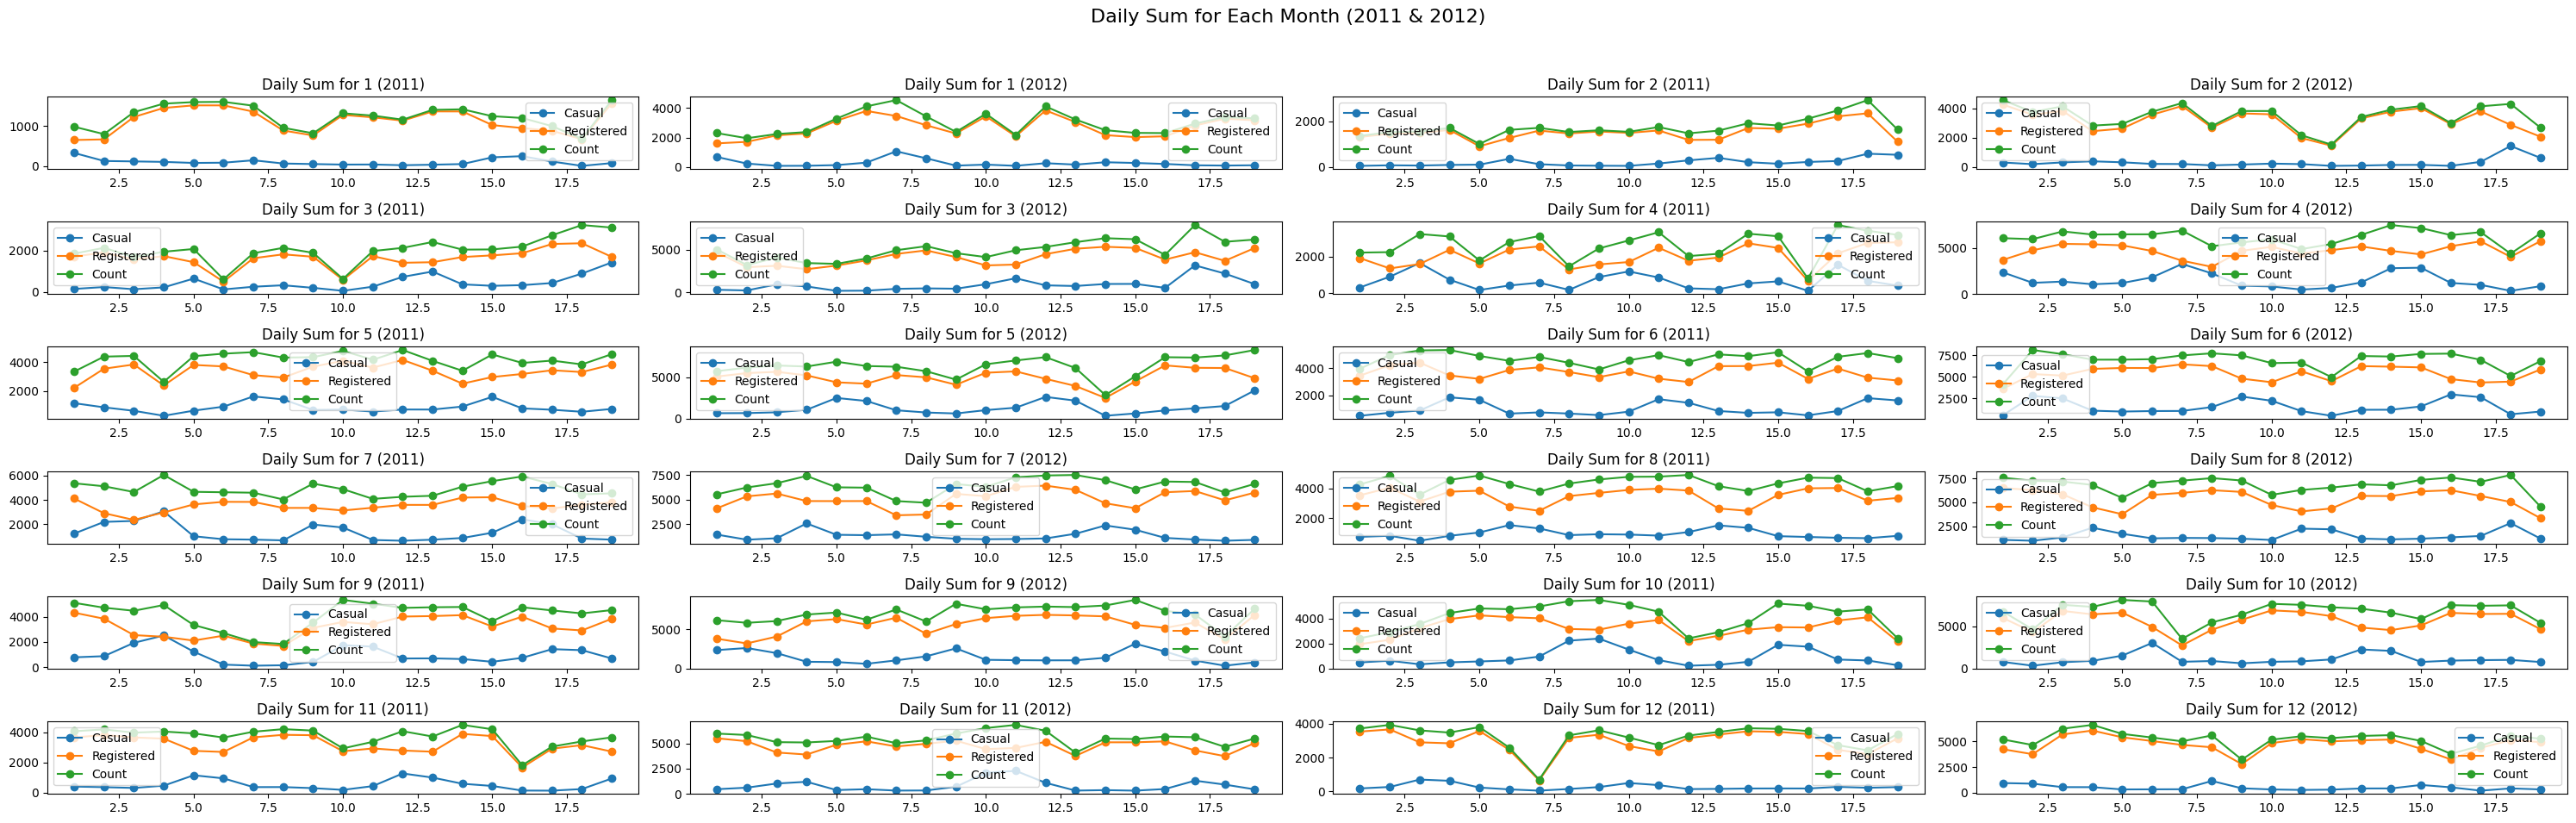

In [16]:
# 月ごとに日ごとの合計を取得する
monthly_dayly_data_2011 = {}
monthly_dayly_data_2012 = {}

for month in range(1, 13):
    # 2011年のデータ
    monthly_dayly_data_2011[month] = df_train[(df_train['year'] == 2011) & (df_train['month'] == month)].groupby(df_train['datetime'].dt.day)[['casual', 'registered', 'count']].sum().reset_index()
    monthly_dayly_data_2011[month].rename(columns={'datetime': 'day'}, inplace=True)
    
    # 2012年のデータ
    monthly_dayly_data_2012[month] = df_train[(df_train['year'] == 2012) & (df_train['month'] == month)].groupby(df_train['datetime'].dt.day)[['casual', 'registered', 'count']].sum().reset_index()
    monthly_dayly_data_2012[month].rename(columns={'datetime': 'day'}, inplace=True)

# 24個のグラフをプロット
fig, axes = plt.subplots(6, 4, figsize=(30, 10))
fig.suptitle("Daily Sum for Each Month (2011 & 2012)", fontsize=16)

for i, month in enumerate(range(1, 13)):
    # 2011年のプロット
    axes[i // 2, (i % 2) * 2].plot(monthly_dayly_data_2011[month]['day'], monthly_dayly_data_2011[month]['casual'], marker='o', label='Casual')
    axes[i // 2, (i % 2) * 2].plot(monthly_dayly_data_2011[month]['day'], monthly_dayly_data_2011[month]['registered'], marker='o', label='Registered')
    axes[i // 2, (i % 2) * 2].plot(monthly_dayly_data_2011[month]['day'], monthly_dayly_data_2011[month]['count'], marker='o', label='Count')
    axes[i // 2, (i % 2) * 2].set_title(f'Daily Sum for {month} (2011)')
    axes[i // 2, (i % 2) * 2].legend()

    # 2012年のプロット
    axes[i // 2, (i % 2) * 2 + 1].plot(monthly_dayly_data_2012[month]['day'], monthly_dayly_data_2012[month]['casual'], marker='o', label='Casual')
    axes[i // 2, (i % 2) * 2 + 1].plot(monthly_dayly_data_2012[month]['day'], monthly_dayly_data_2012[month]['registered'], marker='o', label='Registered')
    axes[i // 2, (i % 2) * 2 + 1].plot(monthly_dayly_data_2012[month]['day'], monthly_dayly_data_2012[month]['count'], marker='o', label='Count')
    axes[i // 2, (i % 2) * 2 + 1].set_title(f'Daily Sum for {month} (2012)')
    axes[i // 2, (i % 2) * 2 + 1].legend()

# レイアウト調整
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

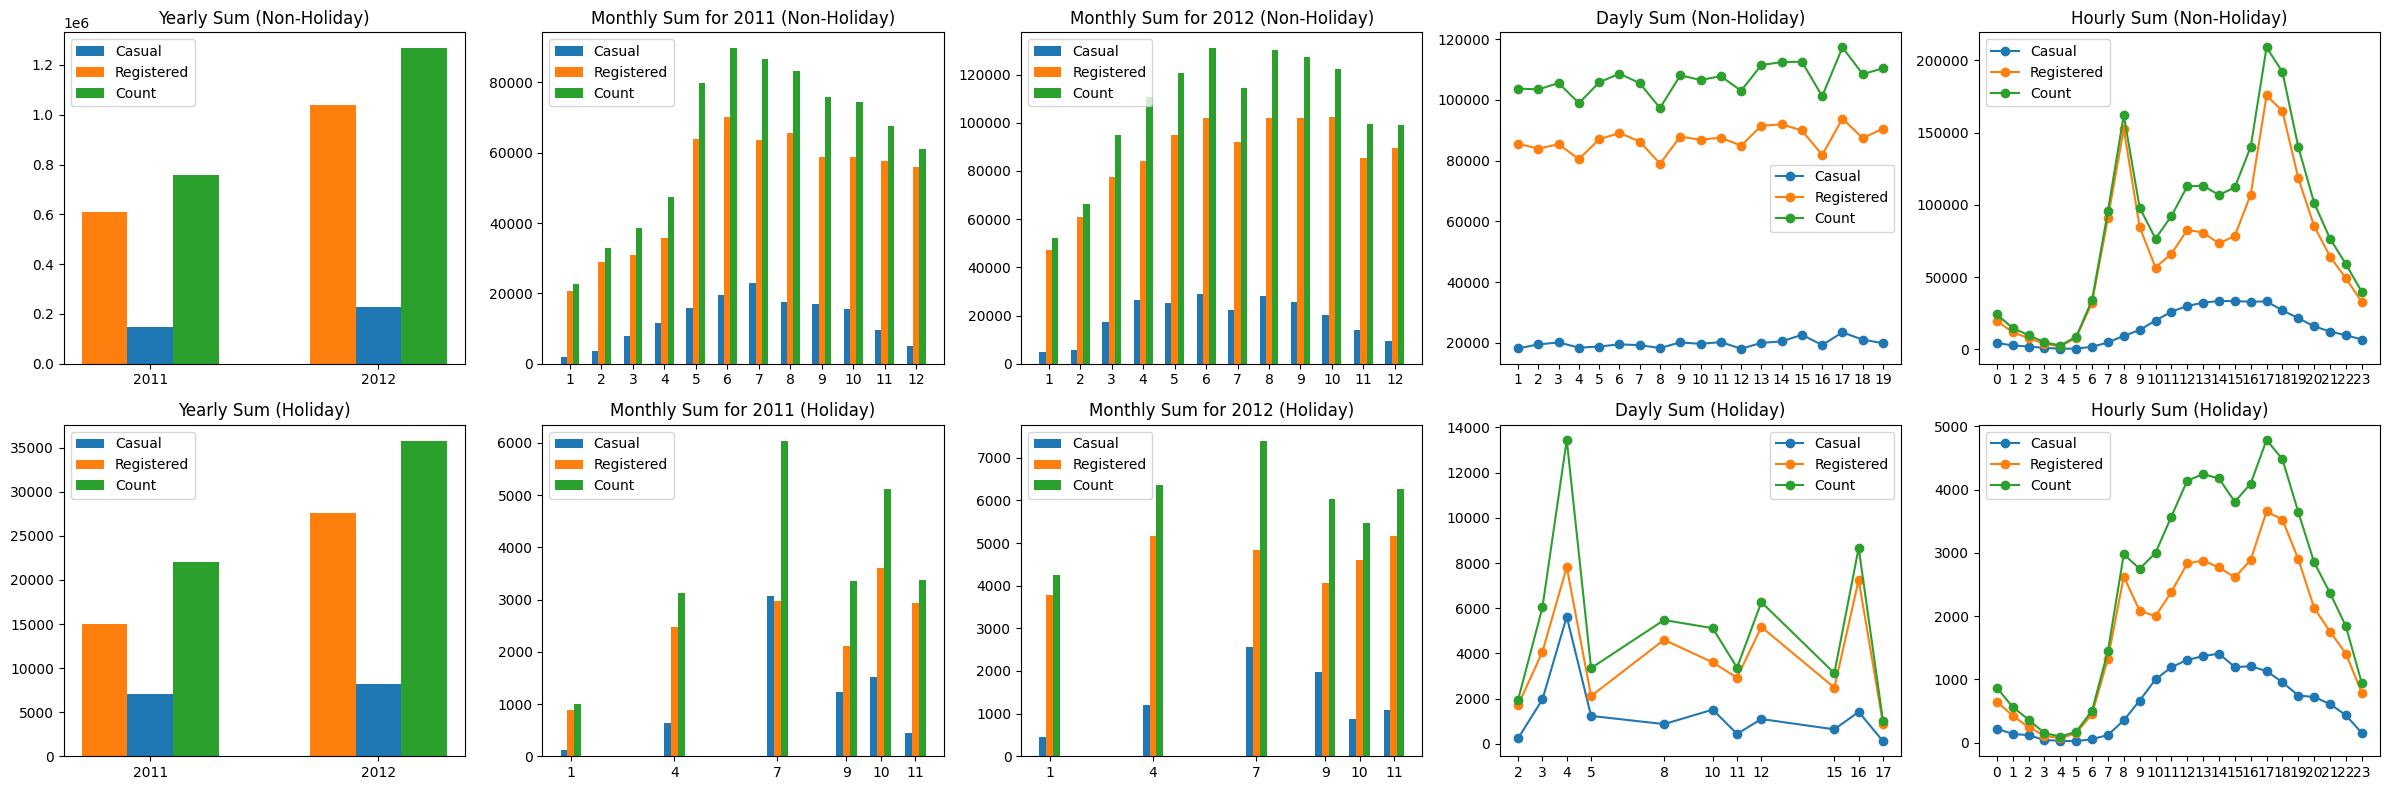

In [17]:
# holidayが0のとき（祝日でない）のデータ
non_holiday_data = df_train[df_train['holiday'] == 0]
yearly_data_non_holiday = non_holiday_data.groupby('year')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2011_non_holiday = non_holiday_data[non_holiday_data['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2012_non_holiday = non_holiday_data[non_holiday_data['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
dayly_data_non_holiday = non_holiday_data.groupby('day')[['casual', 'registered', 'count']].sum().reset_index()
hourly_data_non_holiday = non_holiday_data.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

# holidayが1のとき（祝日）のデータ
holiday_data = df_train[df_train['holiday'] == 1]
yearly_data_holiday = holiday_data.groupby('year')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2011_holiday = holiday_data[holiday_data['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2012_holiday = holiday_data[holiday_data['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
dayly_data_holiday = holiday_data.groupby('day')[['casual', 'registered', 'count']].sum().reset_index()
hourly_data_holiday = holiday_data.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

# 横一列に並べるプロットの準備
fig, axes = plt.subplots(2, 5, figsize=(24, 8))

# holidayが0のとき（祝日でない）のプロット
# 年ごとの棒グラフ（祝日でない）
axes[0, 0].bar(range(len(yearly_data_non_holiday)), yearly_data_non_holiday['casual'], width=0.2, label='Casual')
axes[0, 0].bar([x - 0.2 for x in range(len(yearly_data_non_holiday))], yearly_data_non_holiday['registered'], width=0.2, label='Registered')
axes[0, 0].bar([x + 0.2 for x in range(len(yearly_data_non_holiday))], yearly_data_non_holiday['count'], width=0.2, label='Count')
axes[0, 0].set_title('Yearly Sum (Non-Holiday)')
axes[0, 0].set_xticks(range(len(yearly_data_non_holiday)))
axes[0, 0].set_xticklabels(yearly_data_non_holiday['year'])
axes[0, 0].legend()

# 月ごとの棒グラフ（2011年、祝日でない）
axes[0, 1].bar(monthly_data_2011_non_holiday['month'] - 0.2, monthly_data_2011_non_holiday['casual'], width=0.2, label='Casual')
axes[0, 1].bar(monthly_data_2011_non_holiday['month'], monthly_data_2011_non_holiday['registered'], width=0.2, label='Registered')
axes[0, 1].bar(monthly_data_2011_non_holiday['month'] + 0.2, monthly_data_2011_non_holiday['count'], width=0.2, label='Count')
axes[0, 1].set_title('Monthly Sum for 2011 (Non-Holiday)')
axes[0, 1].set_xticks(monthly_data_2011_non_holiday['month'])
axes[0, 1].legend()

# 月ごとの棒グラフ（2012年、祝日でない）
axes[0, 2].bar(monthly_data_2012_non_holiday['month'] - 0.2, monthly_data_2012_non_holiday['casual'], width=0.2, label='Casual')
axes[0, 2].bar(monthly_data_2012_non_holiday['month'], monthly_data_2012_non_holiday['registered'], width=0.2, label='Registered')
axes[0, 2].bar(monthly_data_2012_non_holiday['month'] + 0.2, monthly_data_2012_non_holiday['count'], width=0.2, label='Count')
axes[0, 2].set_title('Monthly Sum for 2012 (Non-Holiday)')
axes[0, 2].set_xticks(monthly_data_2012_non_holiday['month'])
axes[0, 2].legend()

# 日ごとの折れ線グラフ（祝日でない）
axes[0, 3].plot(dayly_data_non_holiday['day'], dayly_data_non_holiday['casual'], marker='o', label='Casual')
axes[0, 3].plot(dayly_data_non_holiday['day'], dayly_data_non_holiday['registered'], marker='o', label='Registered')
axes[0, 3].plot(dayly_data_non_holiday['day'], dayly_data_non_holiday['count'], marker='o', label='Count')
axes[0, 3].set_title('Dayly Sum (Non-Holiday)')
axes[0, 3].set_xticks(dayly_data_non_holiday['day'])
axes[0, 3].legend()

# 時間ごとの折れ線グラフ（祝日でない）
axes[0, 4].plot(hourly_data_non_holiday['hour'], hourly_data_non_holiday['casual'], marker='o', label='Casual')
axes[0, 4].plot(hourly_data_non_holiday['hour'], hourly_data_non_holiday['registered'], marker='o', label='Registered')
axes[0, 4].plot(hourly_data_non_holiday['hour'], hourly_data_non_holiday['count'], marker='o', label='Count')
axes[0, 4].set_title('Hourly Sum (Non-Holiday)')
axes[0, 4].set_xticks(hourly_data_non_holiday['hour'])
axes[0, 4].legend()

# holidayが1のとき（祝日）のプロット
# 年ごとの棒グラフ（祝日）
axes[1, 0].bar(range(len(yearly_data_holiday)), yearly_data_holiday['casual'], width=0.2, label='Casual')
axes[1, 0].bar([x - 0.2 for x in range(len(yearly_data_holiday))], yearly_data_holiday['registered'], width=0.2, label='Registered')
axes[1, 0].bar([x + 0.2 for x in range(len(yearly_data_holiday))], yearly_data_holiday['count'], width=0.2, label='Count')
axes[1, 0].set_title('Yearly Sum (Holiday)')
axes[1, 0].set_xticks(range(len(yearly_data_holiday)))
axes[1, 0].set_xticklabels(yearly_data_holiday['year'])
axes[1, 0].legend()

# 月ごとの棒グラフ（2011年、祝日）
axes[1, 1].bar(monthly_data_2011_holiday['month'] - 0.2, monthly_data_2011_holiday['casual'], width=0.2, label='Casual')
axes[1, 1].bar(monthly_data_2011_holiday['month'], monthly_data_2011_holiday['registered'], width=0.2, label='Registered')
axes[1, 1].bar(monthly_data_2011_holiday['month'] + 0.2, monthly_data_2011_holiday['count'], width=0.2, label='Count')
axes[1, 1].set_title('Monthly Sum for 2011 (Holiday)')
axes[1, 1].set_xticks(monthly_data_2011_holiday['month'])
axes[1, 1].legend()

# 月ごとの棒グラフ（2012年、祝日）
axes[1, 2].bar(monthly_data_2012_holiday['month'] - 0.2, monthly_data_2012_holiday['casual'], width=0.2, label='Casual')
axes[1, 2].bar(monthly_data_2012_holiday['month'], monthly_data_2012_holiday['registered'], width=0.2, label='Registered')
axes[1, 2].bar(monthly_data_2012_holiday['month'] + 0.2, monthly_data_2012_holiday['count'], width=0.2, label='Count')
axes[1, 2].set_title('Monthly Sum for 2012 (Holiday)')
axes[1, 2].set_xticks(monthly_data_2012_holiday['month'])
axes[1, 2].legend()

# 日ごとの折れ線グラフ（祝日）
axes[1, 3].plot(dayly_data_holiday['day'], dayly_data_holiday['casual'], marker='o', label='Casual')
axes[1, 3].plot(dayly_data_holiday['day'], dayly_data_holiday['registered'], marker='o', label='Registered')
axes[1, 3].plot(dayly_data_holiday['day'], dayly_data_holiday['count'], marker='o', label='Count')
axes[1, 3].set_title('Dayly Sum (Holiday)')
axes[1, 3].set_xticks(dayly_data_holiday['day'])
axes[1, 3].legend()

# 時間ごとの折れ線グラフ（祝日）
axes[1, 4].plot(hourly_data_holiday['hour'], hourly_data_holiday['casual'], marker='o', label='Casual')
axes[1, 4].plot(hourly_data_holiday['hour'], hourly_data_holiday['registered'], marker='o', label='Registered')
axes[1, 4].plot(hourly_data_holiday['hour'], hourly_data_holiday['count'], marker='o', label='Count')
axes[1, 4].set_title('Hourly Sum (Holiday)')
axes[1, 4].set_xticks(hourly_data_holiday['hour'])
axes[1, 4].legend()

# レイアウト調整
plt.tight_layout()
plt.show()

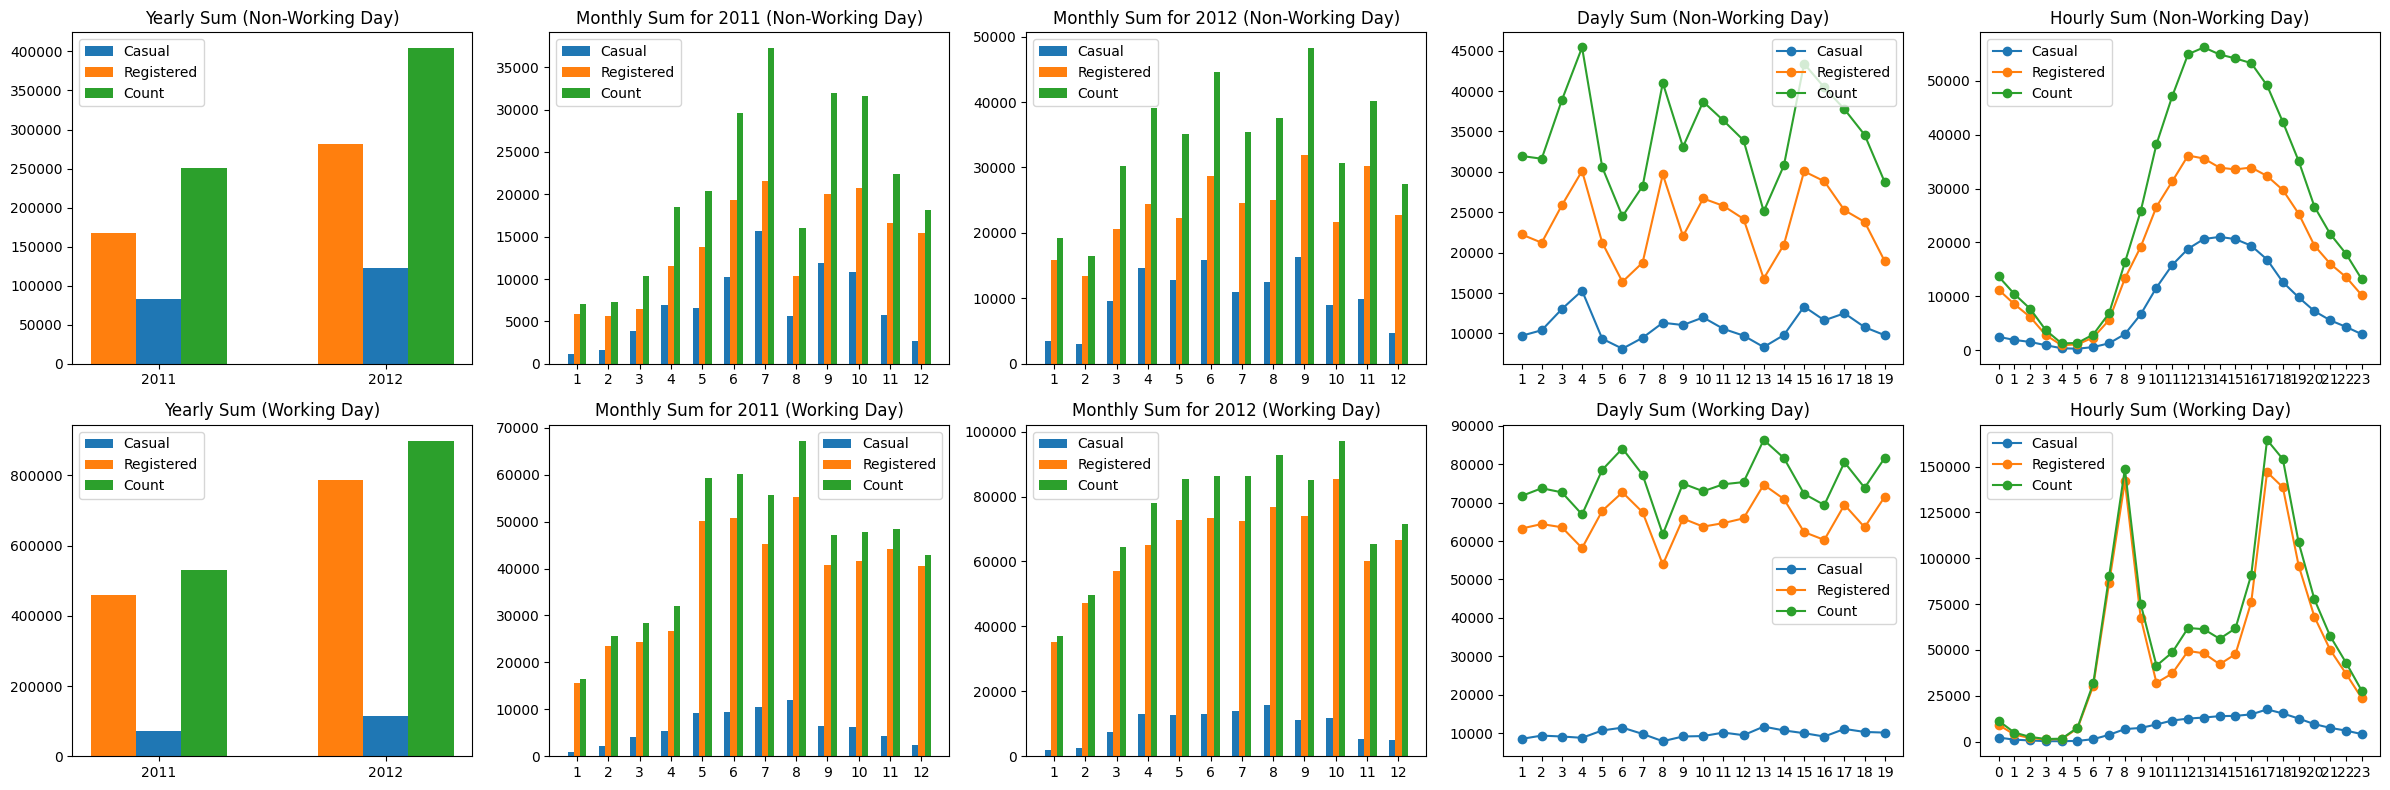

In [18]:
# workingdayが0のとき（非勤務日）のデータ
non_workingday_data = df_train[df_train['workingday'] == 0]
yearly_data_non_workingday = non_workingday_data.groupby('year')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2011_non_workingday = non_workingday_data[non_workingday_data['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2012_non_workingday = non_workingday_data[non_workingday_data['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
dayly_data_non_workingday = non_workingday_data.groupby('day')[['casual', 'registered', 'count']].sum().reset_index()
hourly_data_non_workingday = non_workingday_data.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

# workingdayが1のとき（勤務日）のデータ
workingday_data = df_train[df_train['workingday'] == 1]
yearly_data_workingday = workingday_data.groupby('year')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2011_workingday = workingday_data[workingday_data['year'] == 2011].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
monthly_data_2012_workingday = workingday_data[workingday_data['year'] == 2012].groupby('month')[['casual', 'registered', 'count']].sum().reset_index()
dayly_data_workingday = workingday_data.groupby('day')[['casual', 'registered', 'count']].sum().reset_index()
hourly_data_workingday = workingday_data.groupby('hour')[['casual', 'registered', 'count']].sum().reset_index()

# 横一列に並べるプロットの準備
fig, axes = plt.subplots(2, 5, figsize=(24, 8))

# workingdayが0のとき（非勤務日）のプロット
# 年ごとの棒グラフ（非勤務日）
axes[0, 0].bar(range(len(yearly_data_non_workingday)), yearly_data_non_workingday['casual'], width=0.2, label='Casual')
axes[0, 0].bar([x - 0.2 for x in range(len(yearly_data_non_workingday))], yearly_data_non_workingday['registered'], width=0.2, label='Registered')
axes[0, 0].bar([x + 0.2 for x in range(len(yearly_data_non_workingday))], yearly_data_non_workingday['count'], width=0.2, label='Count')
axes[0, 0].set_title('Yearly Sum (Non-Working Day)')
axes[0, 0].set_xticks(range(len(yearly_data_non_workingday)))
axes[0, 0].set_xticklabels(yearly_data_non_workingday['year'])
axes[0, 0].legend()

# 月ごとの棒グラフ（2011年、非勤務日）
axes[0, 1].bar(monthly_data_2011_non_workingday['month'] - 0.2, monthly_data_2011_non_workingday['casual'], width=0.2, label='Casual')
axes[0, 1].bar(monthly_data_2011_non_workingday['month'], monthly_data_2011_non_workingday['registered'], width=0.2, label='Registered')
axes[0, 1].bar(monthly_data_2011_non_workingday['month'] + 0.2, monthly_data_2011_non_workingday['count'], width=0.2, label='Count')
axes[0, 1].set_title('Monthly Sum for 2011 (Non-Working Day)')
axes[0, 1].set_xticks(monthly_data_2011_non_workingday['month'])
axes[0, 1].legend()

# 月ごとの棒グラフ（2012年、非勤務日）
axes[0, 2].bar(monthly_data_2012_non_workingday['month'] - 0.2, monthly_data_2012_non_workingday['casual'], width=0.2, label='Casual')
axes[0, 2].bar(monthly_data_2012_non_workingday['month'], monthly_data_2012_non_workingday['registered'], width=0.2, label='Registered')
axes[0, 2].bar(monthly_data_2012_non_workingday['month'] + 0.2, monthly_data_2012_non_workingday['count'], width=0.2, label='Count')
axes[0, 2].set_title('Monthly Sum for 2012 (Non-Working Day)')
axes[0, 2].set_xticks(monthly_data_2012_non_workingday['month'])
axes[0, 2].legend()

# 日ごとの折れ線グラフ（非勤務日）
axes[0, 3].plot(dayly_data_non_workingday['day'], dayly_data_non_workingday['casual'], marker='o', label='Casual')
axes[0, 3].plot(dayly_data_non_workingday['day'], dayly_data_non_workingday['registered'], marker='o', label='Registered')
axes[0, 3].plot(dayly_data_non_workingday['day'], dayly_data_non_workingday['count'], marker='o', label='Count')
axes[0, 3].set_title('Dayly Sum (Non-Working Day)')
axes[0, 3].set_xticks(dayly_data_non_workingday['day'])
axes[0, 3].legend()

# 時間ごとの折れ線グラフ（非勤務日）
axes[0, 4].plot(hourly_data_non_workingday['hour'], hourly_data_non_workingday['casual'], marker='o', label='Casual')
axes[0, 4].plot(hourly_data_non_workingday['hour'], hourly_data_non_workingday['registered'], marker='o', label='Registered')
axes[0, 4].plot(hourly_data_non_workingday['hour'], hourly_data_non_workingday['count'], marker='o', label='Count')
axes[0, 4].set_title('Hourly Sum (Non-Working Day)')
axes[0, 4].set_xticks(hourly_data_non_workingday['hour'])
axes[0, 4].legend()

# workingdayが1のとき（勤務日）のプロット
# 年ごとの棒グラフ（勤務日）
axes[1, 0].bar(range(len(yearly_data_workingday)), yearly_data_workingday['casual'], width=0.2, label='Casual')
axes[1, 0].bar([x - 0.2 for x in range(len(yearly_data_workingday))], yearly_data_workingday['registered'], width=0.2, label='Registered')
axes[1, 0].bar([x + 0.2 for x in range(len(yearly_data_workingday))], yearly_data_workingday['count'], width=0.2, label='Count')
axes[1, 0].set_title('Yearly Sum (Working Day)')
axes[1, 0].set_xticks(range(len(yearly_data_workingday)))
axes[1, 0].set_xticklabels(yearly_data_workingday['year'])
axes[1, 0].legend()

# 月ごとの棒グラフ（2011年、勤務日）
axes[1, 1].bar(monthly_data_2011_workingday['month'] - 0.2, monthly_data_2011_workingday['casual'], width=0.2, label='Casual')
axes[1, 1].bar(monthly_data_2011_workingday['month'], monthly_data_2011_workingday['registered'], width=0.2, label='Registered')
axes[1, 1].bar(monthly_data_2011_workingday['month'] + 0.2, monthly_data_2011_workingday['count'], width=0.2, label='Count')
axes[1, 1].set_title('Monthly Sum for 2011 (Working Day)')
axes[1, 1].set_xticks(monthly_data_2011_workingday['month'])
axes[1, 1].legend()

# 月ごとの棒グラフ（2012年、勤務日）
axes[1, 2].bar(monthly_data_2012_workingday['month'] - 0.2, monthly_data_2012_workingday['casual'], width=0.2, label='Casual')
axes[1, 2].bar(monthly_data_2012_workingday['month'], monthly_data_2012_workingday['registered'], width=0.2, label='Registered')
axes[1, 2].bar(monthly_data_2012_workingday['month'] + 0.2, monthly_data_2012_workingday['count'], width=0.2, label='Count')
axes[1, 2].set_title('Monthly Sum for 2012 (Working Day)')
axes[1, 2].set_xticks(monthly_data_2012_workingday['month'])
axes[1, 2].legend()

# 日ごとの折れ線グラフ（勤務日）
axes[1, 3].plot(dayly_data_workingday['day'], dayly_data_workingday['casual'], marker='o', label='Casual')
axes[1, 3].plot(dayly_data_workingday['day'], dayly_data_workingday['registered'], marker='o', label='Registered')
axes[1, 3].plot(dayly_data_workingday['day'], dayly_data_workingday['count'], marker='o', label='Count')
axes[1, 3].set_title('Dayly Sum (Working Day)')
axes[1, 3].set_xticks(dayly_data_workingday['day'])
axes[1, 3].legend()

# 時間ごとの折れ線グラフ（勤務日）
axes[1, 4].plot(hourly_data_workingday['hour'], hourly_data_workingday['casual'], marker='o', label='Casual')
axes[1, 4].plot(hourly_data_workingday['hour'], hourly_data_workingday['registered'], marker='o', label='Registered')
axes[1, 4].plot(hourly_data_workingday['hour'], hourly_data_workingday['count'], marker='o', label='Count')
axes[1, 4].set_title('Hourly Sum (Working Day)')
axes[1, 4].set_xticks(hourly_data_workingday['hour'])
axes[1, 4].legend()

# レイアウト調整
plt.tight_layout()
plt.show()

# モデルの選定
* 時系列モデル
  * Prophet
* 決定木モデル
  * Random Forest
  * LightGBM  

In [19]:
# モデルの定義

# RandomForestモデル（デフォルト設定）
RF_casual_model = RandomForestRegressor(random_state=42)
RF_registered_model = RandomForestRegressor(random_state=42)

# LightGBMモデル（デフォルト設定）
LGB_casual_model = LGBMRegressor(random_state=42, verbosity=-1)
LGB_registered_model = LGBMRegressor(random_state=42, verbosity=-1)

In [20]:
# RMSLE評価関数
def evaluate_model_rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [21]:
# Prophetの定義と学習関数
def train_and_evaluate_prophet(data, target_column):
    # 説明変数を自動的に取得
    regressors = [col for col in data.columns if col not in ["datetime", target_column]]
    
    print(f"Using the following regressors: {regressors}")

    # データをProphetの形式に変換
    data = data.rename(columns={"datetime": "ds", target_column: "y"})
    
    # 訓練データと検証データを分割
    train_data = data[(data['day'] <= 18)]
    valid_data = data[(data['day'] == 19) & (data['year'] == 2012) & (data['month'] == 12)]

    # Prophetモデルの作成
    prophet_model = Prophet()
    #prophet_model.add_seasonality(name='hourly', period=24, fourier_order=10)
    for regressor in regressors:
        prophet_model.add_regressor(regressor)

    # モデルの学習
    prophet_model.fit(train_data[["ds"] + regressors + ["y"]])

    # 検証データの予測
    future = valid_data[["ds"] + regressors]
    forecast = prophet_model.predict(future)

    # 予測値とRMSLEの計算
    y_pred = forecast['yhat'].clip(lower=0)  # マイナスの予測値を0にクリップ

    rmsle = evaluate_model_rmsle(valid_data["y"], y_pred)

    print(f"{target_column.capitalize()} Prediction - RMSLE: {rmsle:.3f}")
    return prophet_model, rmsle, y_pred

# countの算出とRMSLEの計算
def count_combined_rmsle_prophet(casual_pred, registered_pred, df_train_count, model_name, plot=True):
    # casualとregisteredの予測値を合算
    y_count_pred = casual_pred + registered_pred

    # テストデータのcount列（19日分）
    y_count_true = df_train_count[
        (df_train_count['day'] == 19) &
        (df_train_count['year'] == 2012) &
        (df_train_count['month'] == 12)
    ][['hour', 'count']].reset_index(drop=True)


    # 時間単位で集計（平均を計算）
    y_count_true_hourly = y_count_true.groupby('hour').mean()
    df_pred = pd.DataFrame({
        'hour': y_count_true['hour'],  # y_count_true から直接取得
        'predicted_count': y_count_pred
    })
    y_count_pred_hourly = df_pred.groupby('hour').mean()
    
    # RMSLEの計算
    count_rmsle = evaluate_model_rmsle(y_count_true['count'], y_count_pred)
    print(f"\nCount Prediction - RMSLE: {count_rmsle:.3f}")

    # plotting
    if plot:
        plot_hourly_count_predictions(
            true_count=y_count_true_hourly['count'],
            predicted_count=y_count_pred_hourly['predicted_count'],
            model_name=model_name
        )

    return count_rmsle

In [22]:
# 決定木モデルの学習関数
def train_and_evaluate_model(data, model, drop_column=[], tranlate_log=False):
    # 最終列をターゲット列として自動取得
    target_column = data.columns[-1]

    # 1日から18日を訓練データ、19日を検証データに指定
    train_data = data[data['day'] <= 18]
    valid_data = data[data['day'] == 19]

    # 訓練と検証のデータから指定された列を削除
    X_train, X_valid = train_data.drop(columns=["datetime", target_column] + drop_column), valid_data.drop(columns=["datetime", target_column] + drop_column)
    y_train, y_valid = train_data[target_column], valid_data[target_column]

    # モデルの学習
    model_fold = copy.deepcopy(model)
    if tranlate_log:
        model_fold.fit(X_train, np.log1p(y_train))
    else:
        model_fold.fit(X_train, y_train)

    # validデータに対する評価
    y_pred = model_fold.predict(X_valid)
    if tranlate_log:
        rmsle = evaluate_model_rmsle(y_valid, np.expm1(y_pred))
        y_pred = np.expm1(y_pred)  # 出力を元に戻す
    else:
        rmsle = evaluate_model_rmsle(y_valid, y_pred)

    print(f"{target_column.capitalize()} Prediction - RMSLE: {rmsle:.3f}")
    return model_fold, rmsle, y_pred

# Count RMSLEの計算
def count_combined_rmsle(casual_pred, registered_pred, df_train_count, model_name, plot=True):
    # casualとregisteredの予測値を合算
    y_count_pred = casual_pred + registered_pred

    # テストデータのcount列（19日分）
    y_count_true = df_train_count[df_train_count['day'] == 19][['hour', 'count']]

    # 時間単位で集計（平均を計算）
    y_count_true_hourly = y_count_true.groupby('hour').mean()
    df_pred = pd.DataFrame({'hour': df_train_count[df_train_count['day'] == 19]['hour'], 'predicted_count': y_count_pred})
    y_count_pred_hourly = df_pred.groupby('hour').mean()
    
    # RMSLEの計算
    count_rmsle = evaluate_model_rmsle(y_count_true['count'], y_count_pred)
    print(f"\nCount Prediction - RMSLE: {count_rmsle:.3f}")

    # plotting
    if plot:
        plot_hourly_count_predictions(
            true_count=y_count_true_hourly['count'],
            predicted_count=y_count_pred_hourly['predicted_count'],
            model_name=model_name
        )

    return count_rmsle

In [23]:
# 時間単位のプロット関数
def plot_hourly_count_predictions(true_count, predicted_count, model_name):
    plt.figure(figsize=(12, 3))
    plt.plot(true_count.index, true_count, label="True Count")
    plt.plot(predicted_count.index, predicted_count, label="Predicted Count")
    # plt.title(model_name)
    plt.xlabel("Hour")
    plt.ylabel("Average Count")
    plt.xticks(range(0, 24))  # 時間の範囲（0~23時）
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

Training Casual Model
Using the following regressors: ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


06:56:24 - cmdstanpy - INFO - Chain [1] start processing
06:56:27 - cmdstanpy - INFO - Chain [1] done processing


Casual Prediction - RMSLE: 1.036

Training Registered Model
Using the following regressors: ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


06:56:27 - cmdstanpy - INFO - Chain [1] start processing
06:56:29 - cmdstanpy - INFO - Chain [1] done processing


Registered Prediction - RMSLE: 1.163

Count Prediction - RMSLE: 1.103


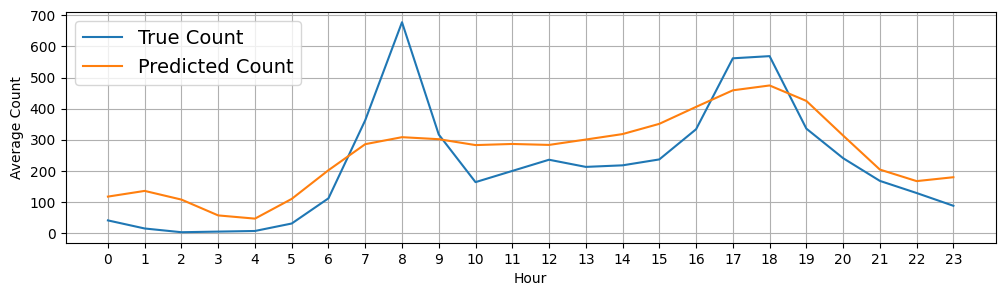

In [24]:
# Prophet

# 学習と評価の実行
print("Training Casual Model")
Prophet_casual_model_trained, Prophet_casual_rmsle, Prophet_casual_pred = train_and_evaluate_prophet(df_train_casual, "casual")

print("\nTraining Registered Model")
Prophet_registered_model_trained, Prophet_registered_rmsle, Prophet_registered_pred = train_and_evaluate_prophet(df_train_registered, "registered")

# 合算したcountのRMSLEを計算
combined_rmsle_prophet = count_combined_rmsle_prophet(Prophet_casual_pred, Prophet_registered_pred, df_train_count, "Prophet")

Training Casual Model
Casual Prediction - RMSLE: 0.617

Training Registered Model
Registered Prediction - RMSLE: 0.318

Count Prediction - RMSLE: 0.346


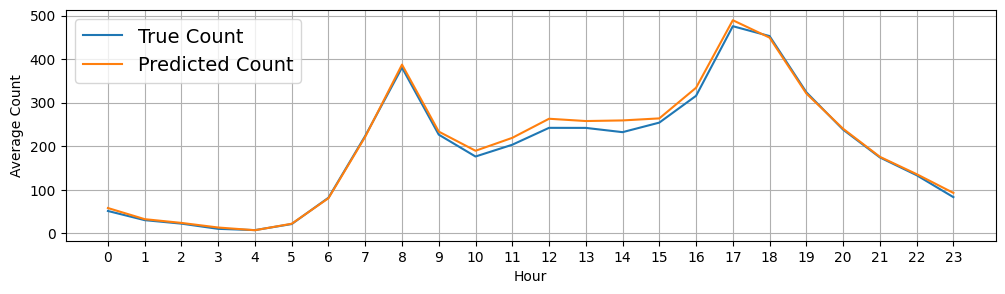

In [25]:
# RandomForest

# 学習と評価の実行
print("Training Casual Model")
RF_casual_model_trained, RF_casual_rmsle, RF_casual_pred = train_and_evaluate_model(df_train_casual, RF_casual_model)

print("\nTraining Registered Model")
RF_registered_model_trained, RF_registered_rmsle, RF_registered_pred = train_and_evaluate_model(df_train_registered, RF_registered_model)

# 合算したcountのRMSLEを計算
combined_rmsle = count_combined_rmsle(RF_casual_pred, RF_registered_pred, df_train_count, "RandomForest")

Training Casual Model
Casual Prediction - RMSLE: 0.601

Training Registered Model
Registered Prediction - RMSLE: 0.419

Count Prediction - RMSLE: 0.419


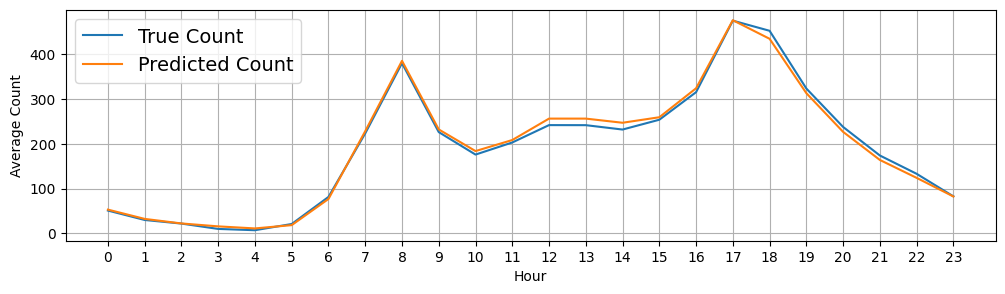

In [26]:
# LightGBM

# 学習と評価の実行
print("Training Casual Model")
LGB_casual_model_trained, LGB_casual_rmsle, LGB_casual_pred = train_and_evaluate_model(df_train_casual, LGB_casual_model)

print("\nTraining Registered Model")
LGB_registered_model_trained, LGB_registered_rmsle, LGB_registered_pred = train_and_evaluate_model(df_train_registered, LGB_registered_model)

# 合算したcountのRMSLEを計算
combined_rmsle = count_combined_rmsle(LGB_casual_pred, LGB_registered_pred, df_train_count, "LightGBM")

# 特徴量エンジニアリング

In [27]:
# weather == 4 のデータを3に変換

def change_weather(df):
    modified_rows = df[df["weather"] == 4]  # weather が 4 の行を抽出
    modified_datetimes = modified_rows["datetime"]  # 該当する datetime 列を取得

    # weather を 4 から 3 に置換
    df.loc[:, "weather"] = df["weather"].replace(4, 3)
    
    # 変更された datetime を表示
    if not modified_datetimes.empty:
        print("Changed datetime rows:")
        print(modified_datetimes)
    else:
        print("No rows were changed.")
    
    return df

df_train_casual = change_weather(df_train_casual)
df_train_registered = change_weather(df_train_registered)
df_train_count = change_weather(df_train_count)
df_test = change_weather(df_test)

display(df_train_casual.head(2))

Changed datetime rows:
5631   2012-01-09 18:00:00
Name: datetime, dtype: datetime64[ns]
Changed datetime rows:
5631   2012-01-09 18:00:00
Name: datetime, dtype: datetime64[ns]
Changed datetime rows:
5631   2012-01-09 18:00:00
Name: datetime, dtype: datetime64[ns]
Changed datetime rows:
154    2011-01-26 16:00:00
3248   2012-01-21 01:00:00
Name: datetime, dtype: datetime64[ns]


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8


In [28]:
# weatherの移動平均を新たな特徴として追加

# weatherの移動平均を計算する関数
def add_weather_moving_average(df, window_size):
    # 既に "weather_ma" が存在する場合，何もしない
    if "weather_ma" in df.columns:
        return df
    
    # 移動平均を計算
    moving_avg = df["weather"].rolling(window=window_size, min_periods=1).mean()
    # 元の weather カラムの次の位置を取得
    weather_col_index = df.columns.get_loc("weather")
    # 新しいカラムを挿入
    df.insert(weather_col_index + 1, "weather_ma", moving_avg)
    return df

# tempの移動平均を計算する関数
def add_temp_moving_average(df, window_size):
    # 既に "temp_ma" が存在する場合，何もしない
    if "temp_ma" in df.columns:
        return df
    
    # 移動平均を計算
    moving_avg = df["temp"].rolling(window=window_size, min_periods=1).mean()
    # 元の temp カラムの次の位置を取得
    temp_col_index = df.columns.get_loc("temp")
    # 新しいカラムを挿入
    df.insert(temp_col_index + 1, "temp_ma", moving_avg)
    return df

# weather : ウィンドウサイズを指定して各データフレームに適用
window_size = 4  
df_train_casual = add_weather_moving_average(df_train_casual, window_size)
df_train_registered = add_weather_moving_average(df_train_registered, window_size)
df_train_count = add_weather_moving_average(df_train_count, window_size)
df_test = add_weather_moving_average(df_test, window_size)

# temp : ウィンドウサイズを指定して各データフレームに適用
window_size = 4  
df_train_casual = add_temp_moving_average(df_train_casual, window_size)
df_train_registered = add_temp_moving_average(df_train_registered, window_size)
df_train_count = add_temp_moving_average(df_train_count, window_size)
df_test = add_temp_moving_average(df_test, window_size)

# 確認
display(df_train_casual.head(2))

,datetime,year,month,day,hour,season,holiday,workingday,weather,weather_ma,temp,temp_ma,atemp,humidity,windspeed,casual
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,1.0,9.84,9.84,14.395,81,0.0,3
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,1.0,9.02,9.43,13.635,80,0.0,8


In [29]:
# 曜日の追加　0（月曜日）～ 6（日曜日）

def add_weekday_column(df):
    # 既に "weekday" が存在する場合，何もしない
    if "weekday" in df.columns:
        return df
    
    # 曜日を計算
    df = df.copy()  # 必要に応じて元のDataFrameを保護
    df.loc[:, 'weekday'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofweek  # 0: 月曜日, 6: 日曜日

    # 'hour' カラムの次に 'weekday' を挿入
    hour_col_index = df.columns.get_loc('hour')
    weekday_values = df.pop('weekday')
    df.insert(hour_col_index + 1, 'weekday', weekday_values)

    return df


df_train_casual = add_weekday_column(df_train_casual)
df_train_registered = add_weekday_column(df_train_registered)
df_train_count = add_weekday_column(df_train_count)
df_test = add_weekday_column(df_test)

# 確認
display(df_train_casual.head(2))

,datetime,year,month,day,hour,weekday,season,holiday,workingday,weather,weather_ma,temp,temp_ma,atemp,humidity,windspeed,casual
0,2011-01-01 00:00:00,2011,1,1,0,5,1,0,0,1,1.0,9.84,9.84,14.395,81,0.0,3
1,2011-01-01 01:00:00,2011,1,1,1,5,1,0,0,1,1.0,9.02,9.43,13.635,80,0.0,8


# 目的変数の対数化とK-fold交差検証の導入

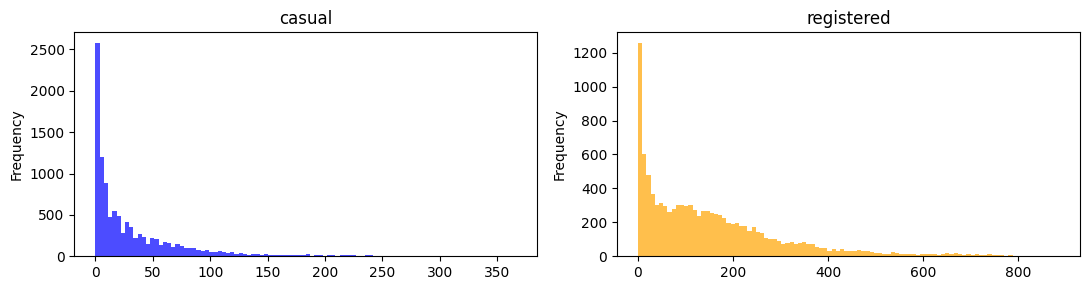

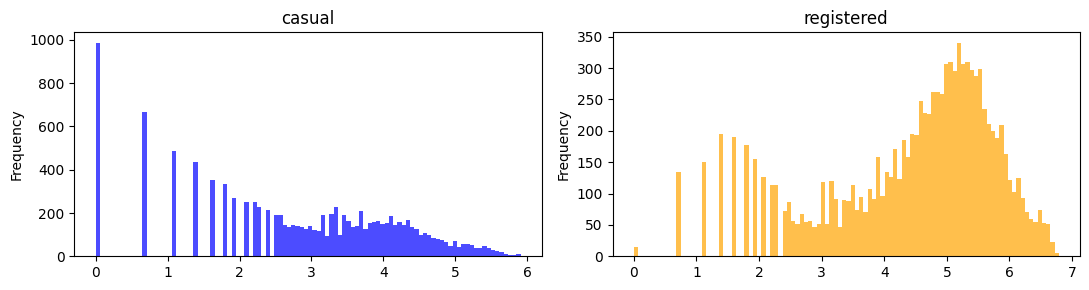

In [30]:
# 目的変数の対数化の確認
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# casual の分布
axes[0].hist(df_train['casual'], bins=100, color='blue', alpha=0.7)
axes[0].set_title('casual')
axes[0].set_ylabel('Frequency')

# registered の分布
axes[1].hist(df_train['registered'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('registered')
axes[1].set_ylabel('Frequency')

# レイアウト調整
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# casual の分布
log_casual = np.log1p(df_train['casual'])  # log(x + 1)
axes[0].hist(log_casual, bins=100, color='blue', alpha=0.7)
axes[0].set_title('casual')
axes[0].set_ylabel('Frequency')

# registered の分布
log_registered = np.log1p(df_train['registered'])  # log(x + 1)
axes[1].hist(log_registered, bins=100, color='orange', alpha=0.7)
axes[1].set_title('registered')
axes[1].set_ylabel('Frequency')

# レイアウト調整
plt.tight_layout()
plt.show()

In [31]:
# 予測モデルの定義

# RandomForestモデル（デフォルト設定）
RF_casual_model = RandomForestRegressor(random_state=42)
RF_registered_model = RandomForestRegressor(random_state=42)

# LightGBMモデル（デフォルト設定）
LGBM_casual_model = LGBMRegressor(random_state=42, verbosity=-1)
LGBM_registered_model = LGBMRegressor(random_state=42, verbosity=-1)

In [32]:
# RMSLE評価関数
def evaluate_model_rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [33]:
# 学習と評価を行う関数

def train_and_evaluate_model(data, model, drop_column, n_splits=5, tranlate_log=True):
    # 最終列をターゲット列として自動取得
    target_column = data.columns[-1]

    # ユニークな日を分割して各foldに分ける
    unique_days = data['day'].unique()
    day_groups = np.array_split(np.sort(unique_days), n_splits)
    # fold結果を出力
    print("Day Groups for each fold:")
    print(" | ".join([f"Fold-{i}: {', '.join(map(str, group))}" for i, group in enumerate(day_groups, start=1)]))

    scores = []
    saved_models = []
    pred_list = []

    for fold, days in enumerate(day_groups, start=1):
        train_data = data[~data['day'].isin(days)]
        valid_data = data[data['day'].isin(days)]

        # 訓練と検証のデータから指定された列を削除
        X_train, X_valid = train_data.drop(columns=["datetime", target_column] + drop_column), valid_data.drop(columns=["datetime", target_column] + drop_column)
        y_train, y_valid = train_data[target_column], valid_data[target_column]

        # モデルの学習
        model_fold = copy.deepcopy(model)
        if tranlate_log:
            model_fold.fit(X_train, np.log1p(y_train))
        else:
            model_fold.fit(X_train, y_train)

        # validデータに対する評価
        y_pred = model_fold.predict(X_valid)
        if tranlate_log:
            rmsle = evaluate_model_rmsle(y_valid, np.expm1(y_pred))
            pred_list.append(np.expm1(y_pred))
        else:
            rmsle = evaluate_model_rmsle(y_valid, y_pred)
            pred_list.append(y_pred)
        scores.append(rmsle)

        # 各モデルの保存
        saved_models.append({"model_name": f"{target_column}_fold_{fold}", "model": copy.deepcopy(model_fold)})

    print(f"{target_column.capitalize()} Prediction - Mean RMSLE: {np.mean(scores):.3f}")
    return saved_models, scores, pred_list

In [34]:
# 予測したcasualとregisteredからcountを計算し，精度を評価する関数

def count_combined_rmsle(casual_pred_list, registered_pred_list, df_train_count, n_splits=5):
    count_scores = []
    # ユニークな日を分割して各foldに分ける
    unique_days = df_train_count['day'].unique()
    day_groups = np.array_split(np.sort(unique_days), n_splits)

    for fold, days in enumerate(day_groups, start=1):
        # casualとregisteredの予測値を取得
        y_casual_pred = casual_pred_list[fold - 1]
        y_registered_pred = registered_pred_list[fold - 1]
        
        # 合算してcountを生成
        y_count_pred = y_casual_pred + y_registered_pred
        
        # テストデータのcount列
        y_count_true = df_train_count[df_train_count['day'].isin(days)]['count']
        
    # RMSLEの計算
    count_rmsle = evaluate_model_rmsle(y_count_true, y_count_pred)
    count_scores.append(count_rmsle)
    
    # 平均したRMSLEを出力
    print(f"\nCount Prediction - Mean RMSLE: {np.mean(count_scores):.3f}")
    return count_scores

In [35]:
# fold数を指定
n_splits = 5

# 除外する説明変数を指定
drop_column = ['month']
#drop_column = []

# Random Forest
print("-"*15, " RandomForest ", "-"*15)
print("Training Casual Model")
RF_casual_models, RF_casual_scores, RF_casual_pred_list = train_and_evaluate_model(df_train_casual, RF_casual_model, drop_column, n_splits)
print("\nTraining Registered Model")
RF_registered_models, RF_registered_scores, RF_registered_pred_list = train_and_evaluate_model(df_train_registered, RF_registered_model, drop_column, n_splits)
RF_combined_scores = count_combined_rmsle(RF_casual_pred_list, RF_registered_pred_list, df_train_count, n_splits)# 合算したcountのRMSLEを計算

# LightGBM
print("\n","-"*15, " LightGBM ", "-"*15)
print("Training Casual Model")
LGBM_casual_models, LGBM_casual_scores, LGBM_casual_pred_list = train_and_evaluate_model(df_train_casual, LGBM_casual_model, drop_column, n_splits)
print("\nTraining Registered Model")
LGBM_registered_models, LGBM_registered_scores, LGBM_registered_pred_list = train_and_evaluate_model(df_train_registered, LGBM_registered_model, drop_column, n_splits)
LGBM_combined_scores = count_combined_rmsle(LGBM_casual_pred_list, LGBM_registered_pred_list, df_train_count, n_splits)# 合算したcountのRMSLEを計算

---------------  RandomForest  ---------------
Training Casual Model
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Casual Prediction - Mean RMSLE: 0.542

Training Registered Model
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Registered Prediction - Mean RMSLE: 0.329

Count Prediction - Mean RMSLE: 0.317

 ---------------  LightGBM  ---------------
Training Casual Model
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Casual Prediction - Mean RMSLE: 0.509

Training Registered Model
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Registered Prediction - Mean RMSLE: 0.304

Count Prediction - Mean RMSLE: 0.293


In [36]:
# テストデータの予測を行い，提出用csvを生成する関数

def predict_test_data(saved_casual_models, saved_registered_models, test_data, drop_column, output_file="submission.csv", translate_log=True):
    # `casual`と`registered`の予測値リスト
    casual_preds = []
    registered_preds = []

    # 各foldごとに予測を行い，平均を計算
    for fold in range(len(saved_casual_models)):
        # モデルの読み込み
        casual_model = saved_casual_models[fold]["model"]
        registered_model = saved_registered_models[fold]["model"]
        print(f"Using {saved_casual_models[fold]['model_name']} and {saved_registered_models[fold]['model_name']} for fold {fold + 1}")

        # テストデータの特徴量を取得
        X_test = test_data.drop(columns=["datetime"] + drop_column)

        # `casual`と`registered`の予測
        if translate_log:
            casual_preds.append(np.expm1(casual_model.predict(X_test)))
            registered_preds.append(np.expm1(registered_model.predict(X_test)))
        else:
            casual_preds.append(casual_model.predict(X_test))
            registered_preds.append(registered_model.predict(X_test))

    # 各foldの予測値を平均して最終予測値を計算
    casual_final_pred = np.mean(casual_preds, axis=0)
    registered_final_pred = np.mean(registered_preds, axis=0)
    count_final_pred = casual_final_pred + registered_final_pred

    # 結果をDataFrameにまとめる
    submission_df = pd.DataFrame({
        "datetime": test_data["datetime"],
        "count": count_final_pred
    })

    # CSVとして保存
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved as {output_file}")

In [37]:
# テストデータの予測とCSV保存

#predict_test_data(RF_casual_models, RF_registered_models, df_test, drop_column, output_file="../out/submission-RF.csv")
#predict_test_data(LGBM_casual_models, LGBM_registered_models, df_test, drop_column, output_file="/kaggle/working/submission-LGBM.csv")

# **Optunaの導入（Light-GBM）**

In [38]:
# ライブラリのインポート
import optuna
from tqdm import tqdm

# ログレベルをエラーのみに設定
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [39]:
# 学習と評価関数を定義

def train_and_evaluate_model_with_optuna(data, drop_column, n_splits=5, tranlate_log=True, params=None):
    target_column = data.columns[-1]
    unique_days = data['day'].unique()
    day_groups = np.array_split(np.sort(unique_days), n_splits)
    scores = []

    for fold, days in enumerate(day_groups, start=1):
        train_data = data[~data['day'].isin(days)]
        valid_data = data[data['day'].isin(days)]

        X_train, X_valid = train_data.drop(columns=["datetime", target_column] + drop_column), valid_data.drop(columns=["datetime", target_column] + drop_column)
        y_train, y_valid = train_data[target_column], valid_data[target_column]

        model = LGBMRegressor(random_state=42, verbosity=-1, **params)
        if tranlate_log:
            model.fit(X_train, np.log1p(y_train))
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        if tranlate_log:
            rmsle = evaluate_model_rmsle(y_valid, np.expm1(y_pred))
        else:
            rmsle = evaluate_model_rmsle(y_valid, y_pred)
        scores.append(rmsle)

    return np.mean(scores)

In [40]:
# Optunaによるハイパーパラメータ探索

def objective(trial, data, drop_column, n_splits):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),  
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    rmsle = train_and_evaluate_model_with_optuna(data, drop_column, n_splits, tranlate_log=True, params=params)
    return rmsle

In [41]:
# Optunaの実行

def optimize_model(data, drop_column, n_splits=5, n_trials=50):
    study = optuna.create_study(direction="minimize")
    pbar = tqdm(total=n_trials, desc="Optuna Optimization Progress")
    
    def objective_with_progress(trial):
        # プログレスバーを更新
        result = objective(trial, data, drop_column, n_splits)
        pbar.update(1)
        return result

    study.optimize(objective_with_progress, n_trials=n_trials)
    pbar.close()
    return study

In [42]:
# OptunaによるLightGBMのパラメータ探索
print("-" * 15, " Optuna LightGBM ", "-" * 15)
print("Optimizing Casual Model")
casual_study = optimize_model(df_train_casual, drop_column, n_splits=n_splits, n_trials=50)
print("Best Parameters for Casual Model:", casual_study.best_params)

print("\nOptimizing Registered Model")
registered_study = optimize_model(df_train_registered, drop_column, n_splits=n_splits, n_trials=50)
print("Best Parameters for Registered Model:", registered_study.best_params)

# 最適化後のモデルで学習と評価
LGBM_casual_model = LGBMRegressor(random_state=42, verbosity=-1, **casual_study.best_params)
LGBM_registered_model = LGBMRegressor(random_state=42, verbosity=-1, **registered_study.best_params)

print("\nTraining Casual Model with Optimized Parameters")
LGBM_casual_models, LGBM_casual_scores, LGBM_casual_pred_list = train_and_evaluate_model(df_train_casual, LGBM_casual_model, drop_column, n_splits)
print("\nTraining Registered Model with Optimized Parameters")
LGBM_registered_models, LGBM_registered_scores, LGBM_registered_pred_list = train_and_evaluate_model(df_train_registered, LGBM_registered_model, drop_column, n_splits)
LGBM_combined_scores = count_combined_rmsle(LGBM_casual_pred_list, LGBM_registered_pred_list, df_train_count, n_splits)

---------------  Optuna LightGBM  ---------------
Optimizing Casual Model


Optuna Optimization Progress: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it]


Best Parameters for Casual Model: {'num_leaves': 72, 'max_depth': 6, 'learning_rate': 0.019662071171826313, 'n_estimators': 941, 'min_child_samples': 94, 'subsample': 0.6673483696188948, 'colsample_bytree': 0.7760759854841839}

Optimizing Registered Model


Optuna Optimization Progress: 100%|██████████| 50/50 [04:11<00:00,  5.03s/it]


Best Parameters for Registered Model: {'num_leaves': 181, 'max_depth': 6, 'learning_rate': 0.03636487406606029, 'n_estimators': 660, 'min_child_samples': 23, 'subsample': 0.815961844212956, 'colsample_bytree': 0.9386525998602092}

Training Casual Model with Optimized Parameters
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Casual Prediction - Mean RMSLE: 0.504

Training Registered Model with Optimized Parameters
Day Groups for each fold:
Fold-1: 1, 2, 3, 4 | Fold-2: 5, 6, 7, 8 | Fold-3: 9, 10, 11, 12 | Fold-4: 13, 14, 15, 16 | Fold-5: 17, 18, 19
Registered Prediction - Mean RMSLE: 0.300

Count Prediction - Mean RMSLE: 0.288


In [43]:
# テストデータの予測とCSV保存

# predict_test_data(LGBM_casual_models, LGBM_registered_models, df_test, drop_column, output_file="/kaggle/working/submission-LGBM-final.csv")
predict_test_data(LGBM_casual_models, LGBM_registered_models, df_test, drop_column, output_file="/kaggle/working/submission.csv")

Using casual_fold_1 and registered_fold_1 for fold 1
Using casual_fold_2 and registered_fold_2 for fold 2
Using casual_fold_3 and registered_fold_3 for fold 3
Using casual_fold_4 and registered_fold_4 for fold 4
Using casual_fold_5 and registered_fold_5 for fold 5
Submission file saved as /kaggle/working/submission.csv
